In [1]:
!pip install gym[box2d]

You should consider upgrading via the 'c:\users\brome\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install -e ./ddpg-torch/pybox2d/[all]

Obtaining file:///C:/Users/brome/Documents/TA-AI/OpenAIGym/bipedal-walker/ddpg-torch/pybox2d
  Attempting uninstall: Box2D
    Found existing installation: Box2D 2.3.10
    Uninstalling Box2D-2.3.10:
      Successfully uninstalled Box2D-2.3.10
  Running setup.py develop for Box2D


You should consider upgrading via the 'c:\users\brome\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
!pip show gym

Name: gym
Version: 0.17.2
Summary: The OpenAI Gym: A toolkit for developing and comparing your reinforcement learning agents.
Home-page: https://github.com/openai/gym
Author: OpenAI
Author-email: gym@openai.com
License: UNKNOWN
Location: c:\users\brome\anaconda3\lib\site-packages
Requires: numpy, scipy, cloudpickle, pyglet
Required-by: 


In [2]:
import gym
from gym import envs

In [3]:
env = gym.make('BipedalWalker-v3')
env.reset()
for _ in range(500):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

C:\Users\brome\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class Actor(nn.Module):
    
    def reset_parameters(self):

        self.fc2.weight.data.uniform_(-1.5e-3, 1.5e-3)
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def __init__(self, state_size, action_size, seed, fc_units=300, fc1_units=150):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, fc1_units)
        self.fc3 = nn.Linear(fc1_units, action_size)
        self.reset_parameters()

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu((self.fc1(state)))
        x = F.relu((self.fc2(x)))
        return F.torch.tanh(self.fc3(x))


class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed, fcs1_units=300, fcs2_units=150, fca1_units=150):

        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fcs2 = nn.Linear(fcs1_units, fcs2_units)
        self.fca1 = nn.Linear(action_size, fca1_units)
        self.fc1 = nn.Linear(fcs2_units, 1)
        self.reset_parameters()
                             
    def reset_parameters(self):

        self.fcs2.weight.data.uniform_(-1.5e-3, 1.5e-3)
        self.fc1.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu((self.fcs1(state)))
        xs = self.fcs2(xs)
        xa = self.fca1(action)
        x = F.relu(torch.add(xs, xa))
        return self.fc1(x)

In [13]:
import numpy as np
import copy
import random
from collections import namedtuple, deque

#from model import Actor, Critic

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = 1000000      # replay buffer size
BATCH_SIZE = 100           # minibatch size
GAMMA = 0.80               # discount factor
TAU = 0.001                # for soft update of target parameters
LR_ACTOR = 0.01          # learning rate of the actor
LR_CRITIC = 0.01          # learning rate of the critic
WEIGHT_DECAY = 0     # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)

        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return action

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.4, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [14]:
import gym
import torch
import numpy as np
#from ddpg_agent import Agent
import matplotlib.pyplot as plt

env = gym.make('BipedalWalker-v3')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = Agent(state_size=state_dim, action_size=action_dim, random_seed=0)


def ddpg(episodes, step, pretrained, noise):

    if pretrained:
        agent.actor_local.load_state_dict(torch.load('1checkpoint_actor.pth', map_location="cpu"))
        agent.critic_local.load_state_dict(torch.load('1checkpoint_critic.pth', map_location="cpu"))
        agent.actor_target.load_state_dict(torch.load('1checkpoint_actor.pth', map_location="cpu"))
        agent.critic_target.load_state_dict(torch.load('1checkpoint_critic.pth', map_location="cpu"))

    reward_list = []

    for i in range(episodes):

        state = env.reset()
        score = 0

        for t in range(step):

            env.render()

            action = agent.act(state, noise)
            next_state, reward, done, info = env.step(action[0])
            agent.step(state, action, reward, next_state, done)
            state = next_state.squeeze()
            score += reward

            if done:
                print('Reward: {} | Episode: {}/{}'.format(score, i, episodes))
                break

        reward_list.append(score)

        if score >= 270:
            print('Task Solved')
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            torch.save(agent.actor_target.state_dict(), 'checkpoint_actor_t.pth')
            torch.save(agent.critic_target.state_dict(), 'checkpoint_critic_t.pth')
            break

    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    torch.save(agent.actor_target.state_dict(), 'checkpoint_actor_t.pth')
    torch.save(agent.critic_target.state_dict(), 'checkpoint_critic_t.pth')

    print('Training saved')
    return reward_list


scores = ddpg(episodes=1300, step=2000, pretrained=0, noise=0)
env.close()

Reward: -97.31863038822263 | Episode: 0/1300
Reward: -117.60799678108656 | Episode: 1/1300
Reward: -123.64320069812985 | Episode: 2/1300
Reward: -123.48664721285428 | Episode: 3/1300
Reward: -123.56024497706257 | Episode: 4/1300
Reward: -123.49492116782318 | Episode: 5/1300
Reward: -123.53177240286767 | Episode: 6/1300
Reward: -123.52269164291957 | Episode: 7/1300
Reward: -123.54876347388267 | Episode: 8/1300
Reward: -123.63744158217807 | Episode: 9/1300
Reward: -123.62211872487453 | Episode: 10/1300
Reward: -123.51964015674281 | Episode: 11/1300
Reward: -123.62585211108254 | Episode: 12/1300
Reward: -123.5500436978334 | Episode: 13/1300
Reward: -123.61472532430167 | Episode: 14/1300
Reward: -123.58007409475559 | Episode: 15/1300
Reward: -123.6370725085878 | Episode: 16/1300
Reward: -123.5639095209924 | Episode: 17/1300
Reward: -123.47628463282376 | Episode: 18/1300
Reward: -123.60932207423387 | Episode: 19/1300
Reward: -123.49138347887558 | Episode: 20/1300
Reward: -123.63905183859916

Reward: -123.56766559817643 | Episode: 174/1300
Reward: -123.5958480682609 | Episode: 175/1300
Reward: -123.48537513269856 | Episode: 176/1300
Reward: -123.55652239202337 | Episode: 177/1300
Reward: -123.55945404422594 | Episode: 178/1300
Reward: -123.56199565442094 | Episode: 179/1300
Reward: -123.50520434429995 | Episode: 180/1300
Reward: -123.50754079515241 | Episode: 181/1300
Reward: -123.62548627453671 | Episode: 182/1300
Reward: -123.50742781237514 | Episode: 183/1300
Reward: -123.64154357988512 | Episode: 184/1300
Reward: -123.49883069196531 | Episode: 185/1300
Reward: -123.5919171002613 | Episode: 186/1300
Reward: -123.63137415328497 | Episode: 187/1300
Reward: -123.57018980435842 | Episode: 188/1300
Reward: -123.63178442835311 | Episode: 189/1300
Reward: -123.63653537388083 | Episode: 190/1300
Reward: -123.55636876283648 | Episode: 191/1300
Reward: -123.59419469719256 | Episode: 192/1300
Reward: -123.52993633587968 | Episode: 193/1300
Reward: -123.4777572625857 | Episode: 194/

Reward: -123.50879965223497 | Episode: 346/1300
Reward: -123.57521414909637 | Episode: 347/1300
Reward: -123.51389884341013 | Episode: 348/1300
Reward: -123.64402143383214 | Episode: 349/1300
Reward: -123.56543474929222 | Episode: 350/1300
Reward: -123.61317898889507 | Episode: 351/1300
Reward: -123.6245904878943 | Episode: 352/1300
Reward: -123.57280118489453 | Episode: 353/1300
Reward: -123.63776610859173 | Episode: 354/1300
Reward: -123.54528210061416 | Episode: 355/1300
Reward: -123.54595196803535 | Episode: 356/1300
Reward: -123.55483238419953 | Episode: 357/1300
Reward: -123.6344651176048 | Episode: 358/1300
Reward: -123.51363166760778 | Episode: 359/1300
Reward: -123.59649909269811 | Episode: 360/1300
Reward: -123.94119109401481 | Episode: 361/1300
Reward: -124.05192016462796 | Episode: 362/1300
Reward: -123.89758876208526 | Episode: 363/1300
Reward: -124.04295175051007 | Episode: 364/1300
Reward: -123.9862010206748 | Episode: 365/1300
Reward: -123.93083822015052 | Episode: 366/

Reward: -123.49105525829333 | Episode: 518/1300
Reward: -123.55428521907082 | Episode: 519/1300
Reward: -123.61469918968281 | Episode: 520/1300
Reward: -123.90850141685146 | Episode: 521/1300
Reward: -123.93681197467882 | Episode: 522/1300
Reward: -123.90284902061026 | Episode: 523/1300
Reward: -123.887913370446 | Episode: 524/1300
Reward: -123.93580301519174 | Episode: 525/1300
Reward: -123.92977339706384 | Episode: 526/1300
Reward: -124.02515095086147 | Episode: 527/1300
Reward: -124.03081052294313 | Episode: 528/1300
Reward: -123.928573600268 | Episode: 529/1300
Reward: -123.91129252611348 | Episode: 530/1300
Reward: -123.99228709247274 | Episode: 531/1300
Reward: -123.97803560436705 | Episode: 532/1300
Reward: -123.97975059608308 | Episode: 533/1300
Reward: -124.03357249119941 | Episode: 534/1300
Reward: -123.49498735505591 | Episode: 535/1300
Reward: -123.62215194220158 | Episode: 536/1300
Reward: -123.54679980227539 | Episode: 537/1300
Reward: -123.51822200516054 | Episode: 538/1

Reward: -123.98663703641236 | Episode: 690/1300
Reward: -124.04348081701437 | Episode: 691/1300
Reward: -123.91689356806378 | Episode: 692/1300
Reward: -123.92905909880375 | Episode: 693/1300
Reward: -123.9941310004983 | Episode: 694/1300
Reward: -123.88577782116212 | Episode: 695/1300
Reward: -124.00285283144254 | Episode: 696/1300
Reward: -123.91306477523099 | Episode: 697/1300
Reward: -124.01291279116336 | Episode: 698/1300
Reward: -123.49519985353078 | Episode: 699/1300
Reward: -123.60065031251065 | Episode: 700/1300
Reward: -123.48697492516723 | Episode: 701/1300
Reward: -123.50242070781502 | Episode: 702/1300
Reward: -123.60877779604992 | Episode: 703/1300
Reward: -123.52876011512677 | Episode: 704/1300
Reward: -123.53575724399774 | Episode: 705/1300
Reward: -123.53783393214272 | Episode: 706/1300
Reward: -123.52742975691768 | Episode: 707/1300
Reward: -123.56348940184466 | Episode: 708/1300
Reward: -123.49945362817931 | Episode: 709/1300
Reward: -123.58788761858955 | Episode: 71

Reward: -124.05692421662312 | Episode: 862/1300
Reward: -123.59222245710716 | Episode: 863/1300
Reward: -123.59364129127128 | Episode: 864/1300
Reward: -123.63405018398352 | Episode: 865/1300
Reward: -123.55143747189209 | Episode: 866/1300
Reward: -123.62724867196879 | Episode: 867/1300
Reward: -123.64383872922014 | Episode: 868/1300
Reward: -123.49729960688825 | Episode: 869/1300
Reward: -123.62591037896898 | Episode: 870/1300
Reward: -123.58901146199369 | Episode: 871/1300
Reward: -123.51824715381923 | Episode: 872/1300
Reward: -123.50404278178824 | Episode: 873/1300
Reward: -123.57312709261478 | Episode: 874/1300
Reward: -123.48821959417128 | Episode: 875/1300
Reward: -123.51795733112345 | Episode: 876/1300
Reward: -123.62194929168685 | Episode: 877/1300
Reward: -123.61833918534654 | Episode: 878/1300
Reward: -123.6283515712476 | Episode: 879/1300
Reward: -123.59038432972321 | Episode: 880/1300
Reward: -123.88539264329711 | Episode: 881/1300
Reward: -123.91447268210973 | Episode: 88

Reward: -123.48848531532538 | Episode: 1033/1300
Reward: -123.48401305348736 | Episode: 1034/1300
Reward: -123.50561881652848 | Episode: 1035/1300
Reward: -123.50615953325729 | Episode: 1036/1300
Reward: -123.5393650349925 | Episode: 1037/1300
Reward: -123.59745073968048 | Episode: 1038/1300
Reward: -123.61493849379445 | Episode: 1039/1300
Reward: -123.48147138593845 | Episode: 1040/1300
Reward: -124.04984097246702 | Episode: 1041/1300
Reward: -123.89987398290077 | Episode: 1042/1300
Reward: -124.0217969666111 | Episode: 1043/1300
Reward: -123.91144225212746 | Episode: 1044/1300
Reward: -123.93733901136557 | Episode: 1045/1300
Reward: -123.91789782320771 | Episode: 1046/1300
Reward: -123.9321147926959 | Episode: 1047/1300
Reward: -124.01218725145175 | Episode: 1048/1300
Reward: -123.99482365715008 | Episode: 1049/1300
Reward: -124.02699914188435 | Episode: 1050/1300
Reward: -124.00185935115753 | Episode: 1051/1300
Reward: -124.04142327321382 | Episode: 1052/1300
Reward: -124.0092514161

Reward: -123.99634062197991 | Episode: 1201/1300
Reward: -123.98912919353384 | Episode: 1202/1300
Reward: -123.99412322876667 | Episode: 1203/1300
Reward: -123.91162019853482 | Episode: 1204/1300
Reward: -122.65362799774172 | Episode: 1205/1300
Reward: -124.05068329971904 | Episode: 1206/1300
Reward: -123.98716584416417 | Episode: 1207/1300
Reward: -123.9131635835891 | Episode: 1208/1300
Reward: -124.01328928933481 | Episode: 1209/1300
Reward: -123.89880848413955 | Episode: 1210/1300
Reward: -124.05786445529202 | Episode: 1211/1300
Reward: -123.92366799007792 | Episode: 1212/1300
Reward: -123.99667057001032 | Episode: 1213/1300
Reward: -123.9190081181191 | Episode: 1214/1300
Reward: -124.02188188910483 | Episode: 1215/1300
Reward: -123.92323625974359 | Episode: 1216/1300
Reward: -123.92916716210235 | Episode: 1217/1300
Reward: -124.0555409123376 | Episode: 1218/1300
Reward: -123.9780589414481 | Episode: 1219/1300
Reward: -122.65470214554045 | Episode: 1220/1300
Reward: -123.98323758833

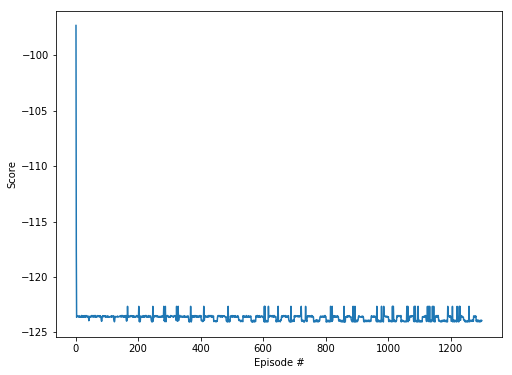

In [15]:
fig = plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('episodes10000v2.png')
plt.show()

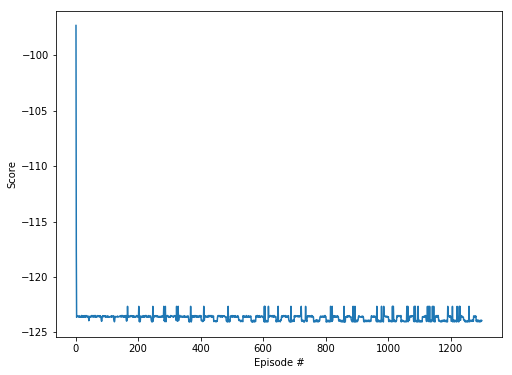

In [16]:
fig = plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('episodes_hardcore10000v2.png')
plt.show()

In [17]:
import numpy as np

In [14]:
np.savetxt('bipedal_scores.txt', np.array(scores))

In [15]:
scores

[-92.59647762272508,
 -95.24957763123513,
 -105.2948873630939,
 -162.58186149919504,
 -128.186327895858,
 -127.92999218980161,
 -125.83208398252788,
 -123.90061337871477,
 -124.43003618026151,
 -128.16342571461325,
 -127.78695111857292,
 -128.03455230849113,
 -127.89699644212548,
 -128.16931161667156,
 -127.93294725132114,
 -128.0583919673444,
 -126.19741550715516,
 -126.15177515262366,
 -125.94092920925965,
 -126.62365864331275,
 -126.4570017501209,
 -126.45389682216943,
 -125.82223394509096,
 -125.85036944191097,
 -125.84772064594613,
 -125.88484286738559,
 -125.63379529794865,
 -124.53523473061063,
 -124.44820045550293,
 -124.62374490223453,
 -125.03831138047141,
 -124.71276237172881,
 -124.94785510802082,
 -124.31009434345489,
 -124.36170494446158,
 -122.79009308294083,
 -123.70294848946295,
 -123.39195078245302,
 -123.13954328798565,
 -123.30372535700661,
 -123.08733391673925,
 -123.83226374616599,
 -124.14137645125948,
 -124.20641416478281,
 -117.14343866302383,
 -117.55643436950

In [ ]:
np.savetxt('bipedal_hardcore_scores.txt', np.array(scores))

In [ ]:
scores